# Cifar 10 classification performed using a simple Fully Connected Deep Neural Network 

 

Accuracy achieved: 42.52% on test data 

Notebook contains:
1. Exploration of CIFAR 10 dataset 
2. Data Augmentation
3. Training simple Fully connected DNN with Early Stopping
4. Analyzing predictions through visualizations

# Settings to run on Google Colab

Stores the trained models in Google Drive

Comment the following out if running on your own system

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
path = 'gdrive/My Drive/Colab Notebooks/cifar10Project/'
os.listdir(path)

['cifar10TransferLearning.ipynb',
 'TransferLearning_models_Final',
 'dataset',
 'CNN_models',
 'DNN_models',
 'dog.png',
 'cifar10TransferLearning2.ipynb',
 '11_truck.png',
 '9993_dog.png',
 '85_dog.png',
 '1387_truck.png',
 'cifar10DNN.ipynb',
 'cifar10CNN.ipynb',
 'cifar10WebApp.ipynb',
 'cifar10TransferLearningFinal.ipynb',
 'TransferLearning_models']

# Settings to run on your own system

Comment the following out if running on Google Drive

In [1]:
path = ''

In [2]:
# Sets width of jupyter notebook to full
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Folder Structure

Set up an empty folder called *TransferLearning_models* in your working directory(either on your system or on Google Drive) so that the trained models can be saved and accessed from this folder.

Below code prints folder structure in local device.

In [3]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
            
currentDirectory = os.getcwd() # For working on own system
# currentDirectory = path # For working on Google Colab

list_files(os.path.join(currentDirectory, 'DNN_models'))

DNN_models/
    DNN_model3.ckpt
    DNN_model244.ckpt
    DNN_model1.ckpt
    DNN_model0.ckpt
    DNN_model4.ckpt
    DNN_model2.ckpt
    ES/
        model4.ckpt
        model1.ckpt
        model8.ckpt
        model6.ckpt
        model2.ckpt
        model7.ckpt
        model5.ckpt
        model3.ckpt
        model9.ckpt
        model10.ckpt


# 1. Importing Libraries 

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from PIL import Image
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import PIL
import sys
import seaborn as sns
import sklearn.metrics
import pickle
import warnings
warnings.filterwarnings("ignore")

## 1.1 PyTorch Version and checking if GPU is active

In [7]:
# Checking if running on GPU or CPU 

#torch.cuda.set_device(1)

x=torch.Tensor(5,3)
print(x.cuda())

tensor([[3.2346e-36, 0.0000e+00, 3.7835e-44],
        [0.0000e+00,        nan, 0.0000e+00],
        [1.3733e-14, 6.4069e+02, 4.3066e+21],
        [1.1824e+22, 4.3066e+21, 6.3828e+28],
        [3.8016e-39, 2.7061e+23, 0.0000e+00]], device='cuda:0')


In [8]:
print(torch.__version__)

1.1.0


# 2. Exploring the CIFAR-10 dataset

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
metaDataPath = path+'dataset/cifar-10-batches-py/batches.meta'
metaData = unpickle(metaDataPath)
label_names_bin = 'label_names'.encode('utf-8')
labelNames = metaData[label_names_bin]
labelNames = [x.decode() for x in labelNames]
labelNames

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## 2.1 Loading data using torch

### 2.1.1 Data Augmentation

In [7]:
data_aug = True 

In [8]:
data_aug_transforms = []

if data_aug == True:

    data_aug_transforms = [
        transforms.RandomCrop((32,32), padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15),
#         transforms.RandomAffine(degrees=0, translate=(.3,.7)),
#         transforms.ColorJitter(
#                 brightness=float(0.1*np.random.rand(1)),
#                 contrast=float(0.1*np.random.rand(1)),
#                 saturation=float(0.1*np.random.rand(1)),
#                 hue=float(0.1*np.random.rand(1))),
#         
#         transforms.Resize((224,224)),
        transforms.ColorJitter(hue=.25, saturation=.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.RandomGrayscale(p=0.1)
                    ]

In [9]:
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

In [10]:
cifar_dataset = torchvision.datasets.CIFAR10(root=path+'dataset/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root=path+'dataset/',
                                          train=False,
                                          transform=test_transform)

In [11]:
cifar_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset/
    Split: Train

In [12]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset/
    Split: Test

## 2.2 Visualizing one of the members and its properties

In [14]:
def toimage(imgArray):
  
    if len(imgArray.shape) == 3:

        processed = []
        for channel in range(3):
            channelImg = imgArray[:,:, channel]

            for i in range(imgArray.shape[0]):
                for j in range(imgArray.shape[1]):
                    channelImg[i,j] = (channelImg[i,j]+1)/2

            processed.append(channelImg)

        img = np.rollaxis(np.array(processed),0,3)
    else:
        img = imgArray[:,:]

        for i in range(imgArray.shape[0]):
            for j in range(imgArray.shape[1]):
                img[i,j] = (img[i,j]+1)/2
            
       
    #print(img.shape)
    return img
    
  

Image in the train dataset has shape: torch.Size([3, 32, 32])
Label corresponding to image is: 9
Label  9 is: truck


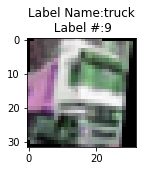

In [15]:
exampleNumber = 1
img = cifar_dataset[exampleNumber][0]
num = cifar_dataset[exampleNumber][1]
# name = cifar_dataset.classes[num]
name = labelNames[num]

print('Image in the train dataset has shape:',img.size())
print('Label corresponding to image is:',num)
print('Label ',num,'is:',name)

img = np.rollaxis(np.array(img),0,3)

plt.figure(figsize=(2,2))
plt.title('Label Name:'+ name+ '\n Label #:'+str(num))
plt.imshow(toimage(img))
plt.show()

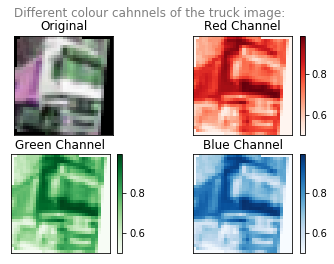

In [16]:
b,g,r = cv2.split(img)
r = toimage(r)
g=toimage(g)
b = toimage(b)

fig, axs = plt.subplots(2,2)

cax_00 = axs[0,0].imshow(img)
axs[0,0].set_title('Original')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])

cax_01 = axs[0,1].imshow(r, cmap='Reds')
axs[0,1].set_title('Red Channel')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
fig.colorbar(cax_01, ax=axs[0,1])

cax_10 = axs[1,0].imshow(g, cmap='Greens')
axs[1,0].set_title('Green Channel')
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
fig.colorbar(cax_10, ax=axs[1,0])

cax_11 = axs[1,1].imshow(b, cmap='Blues')
axs[1,1].set_title('Blue Channel')
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
fig.colorbar(cax_11, ax=axs[1,1])

plt.suptitle('Different colour cahnnels of the '+ name+ ' image:', color ='gray')
plt.show()

In [17]:
r = np.array(r).flatten()
g = np.array(g).flatten()
b = np.array(b).flatten()

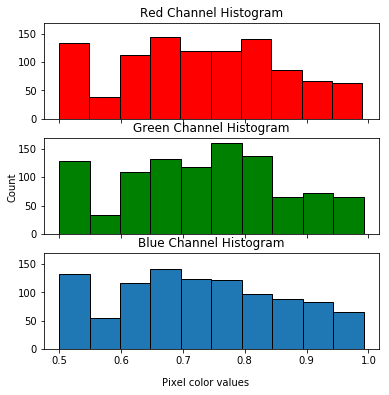

In [18]:
# Plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(6,6))
fig.text(0.5, 0.04, 'Pixel color values', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

axs[0].hist(r, bins=10, color='red', ec='black')
axs[0].set_title('Red Channel Histogram')
axs[1].hist(g.ravel(), bins=10, color='green', ec='black')
axs[1].set_title('Green Channel Histogram')
axs[2].hist(b.ravel(), bins=10, ec='black')
axs[2].set_title('Blue Channel Histogram')

plt.show()

## 2.3 Visualizing all class members

In [19]:
def classMembers(dataset, numMembersOfEachClass = 2):
    
    imagesOfEachClass = {}
    
    for label in range(10):
        imagesOfEachClass[label] = []
        for i in range(numMembersOfEachClass):
            rand = random.randint(0, len(dataset))
            while dataset[rand][1] != label:
                rand = random.randint(0, len(dataset))
            img = dataset[rand][0]
            imagesOfEachClass[label].append(img)
    return imagesOfEachClass

def visualizeClassMembers(imagesOfEachClass, datasetLabelNames):
    rows = len(imagesOfEachClass)
    cols = len(imagesOfEachClass[1])
    
    fig, axs = plt.subplots(figsize=(32.0, 32.0), nrows=rows, ncols=cols)
#     gs1 = gridspec.GridSpec(4, 4)
#     gs1.update(wspace=0.005, hspace=0.005) # set the spacing between axes.
    
    for r in range(rows):
        for c in range(cols):
            img = imagesOfEachClass[r][c-1]
            img = np.rollaxis(np.array(img),0,3)
            col = axs[r,c]
            col.imshow(toimage(img))
            col.set_title(datasetLabelNames[r])
            
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    plt.show()
    
    return None

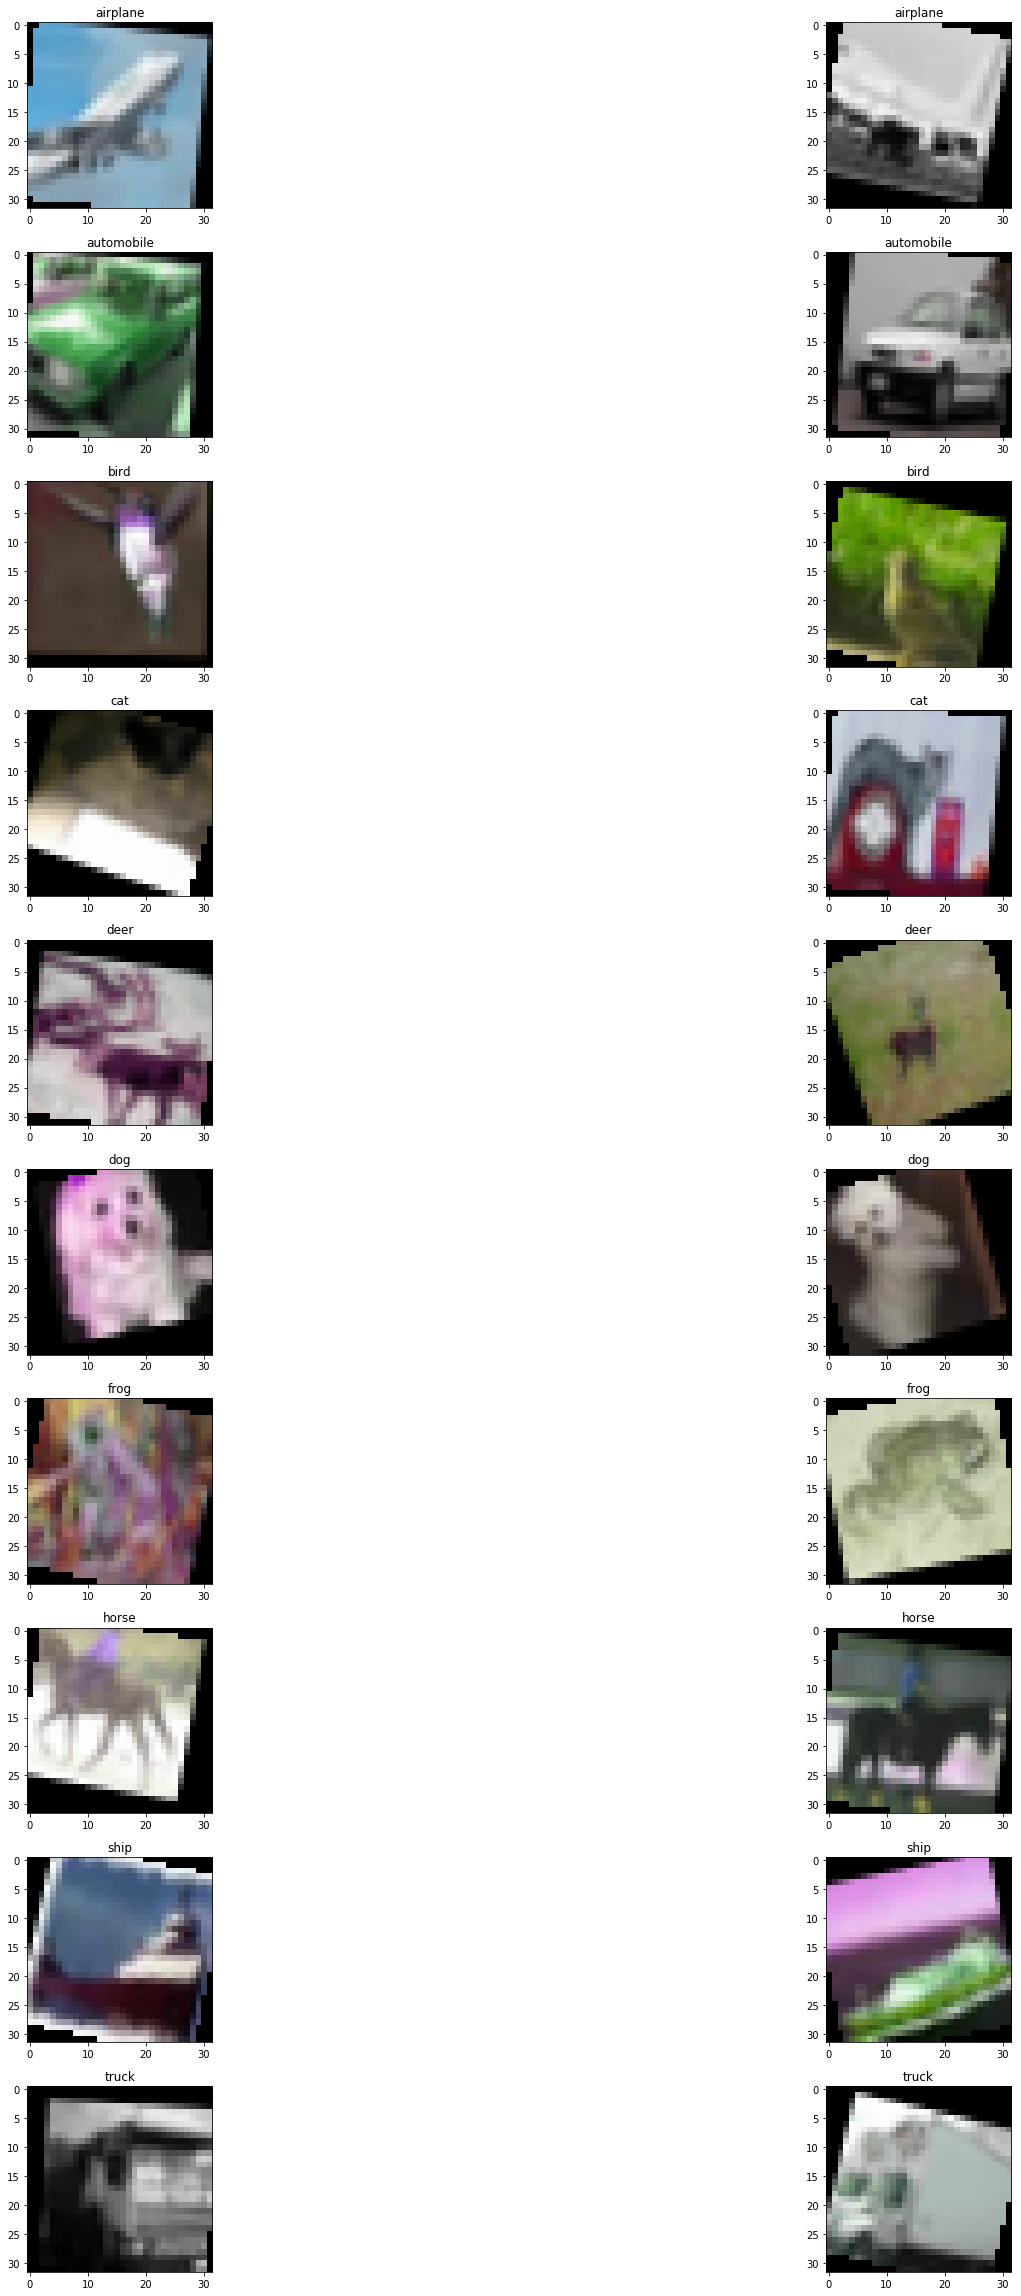

In [20]:
imagesOfEachClass = classMembers(cifar_dataset)
visualizeClassMembers(imagesOfEachClass, labelNames)

## 2.4 Visualize Augmented data

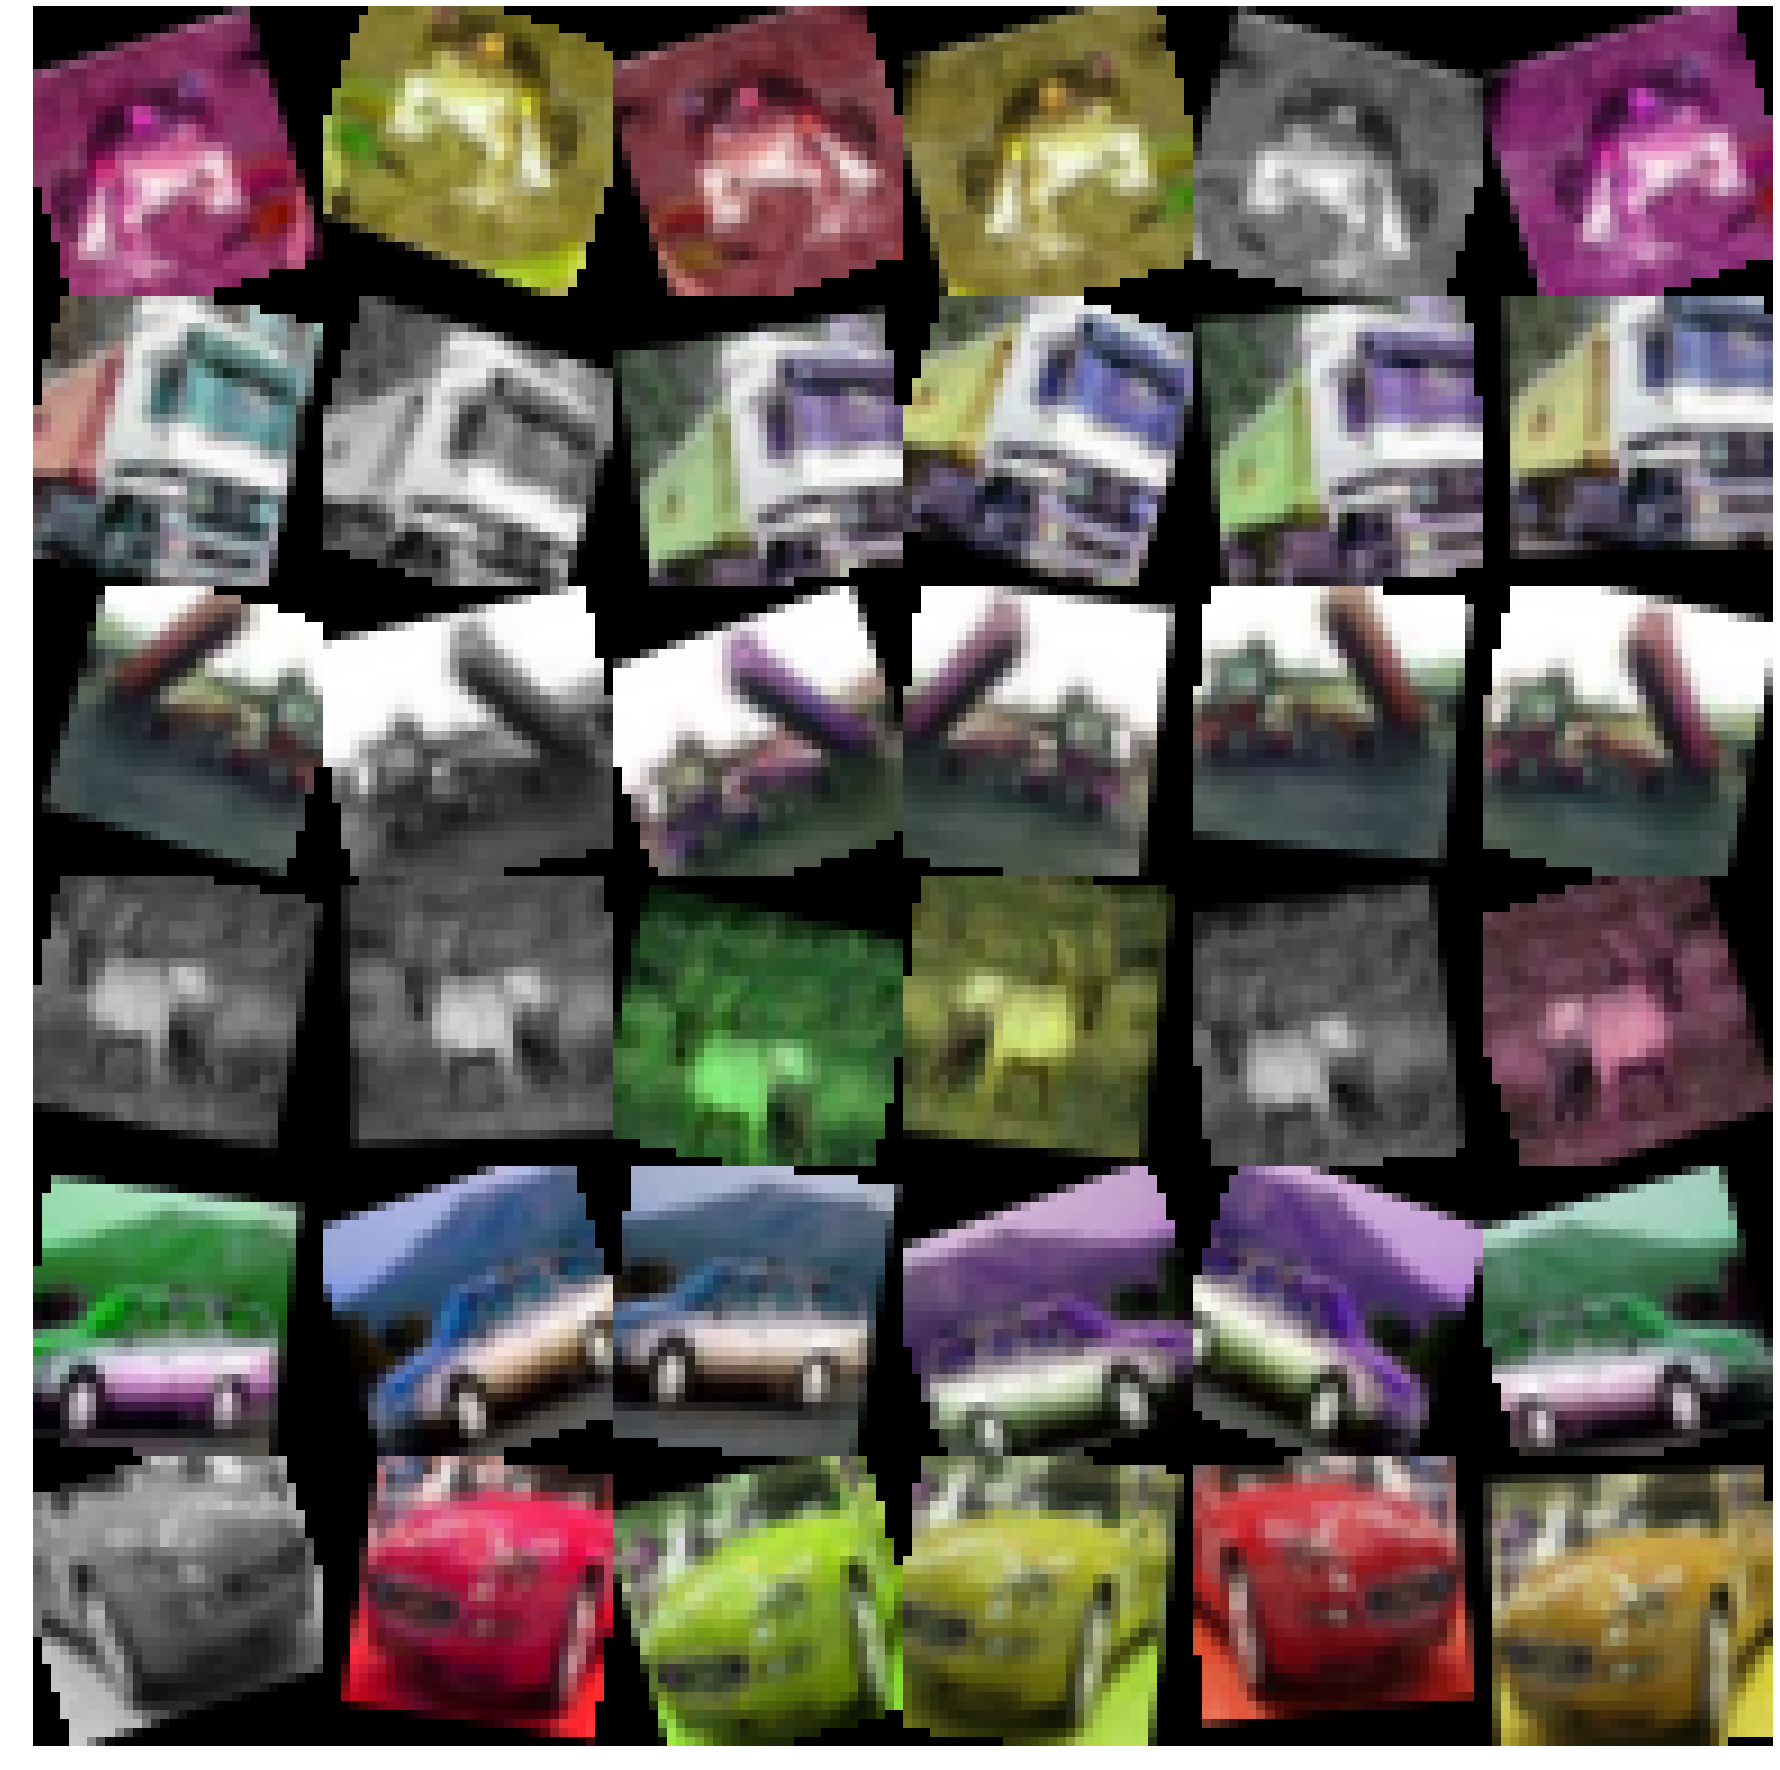

In [21]:
def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(np.rollaxis(np.array(dataset[i][0]),0,3)) for _ in range(n))) 
                     for i in range(n)))
    fig, axs = plt.subplots(1, figsize=(32,32))
    toimage(img)
    axs.imshow(img)
    plt.axis('off')

show_dataset(cifar_dataset)

## 2.5 Visualizing distribution of different classes

In [0]:
def getLabels(dataset):
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][1])
    return labels

trainLabels = getLabels(cifar_dataset)
testLabels = getLabels(test_dataset)

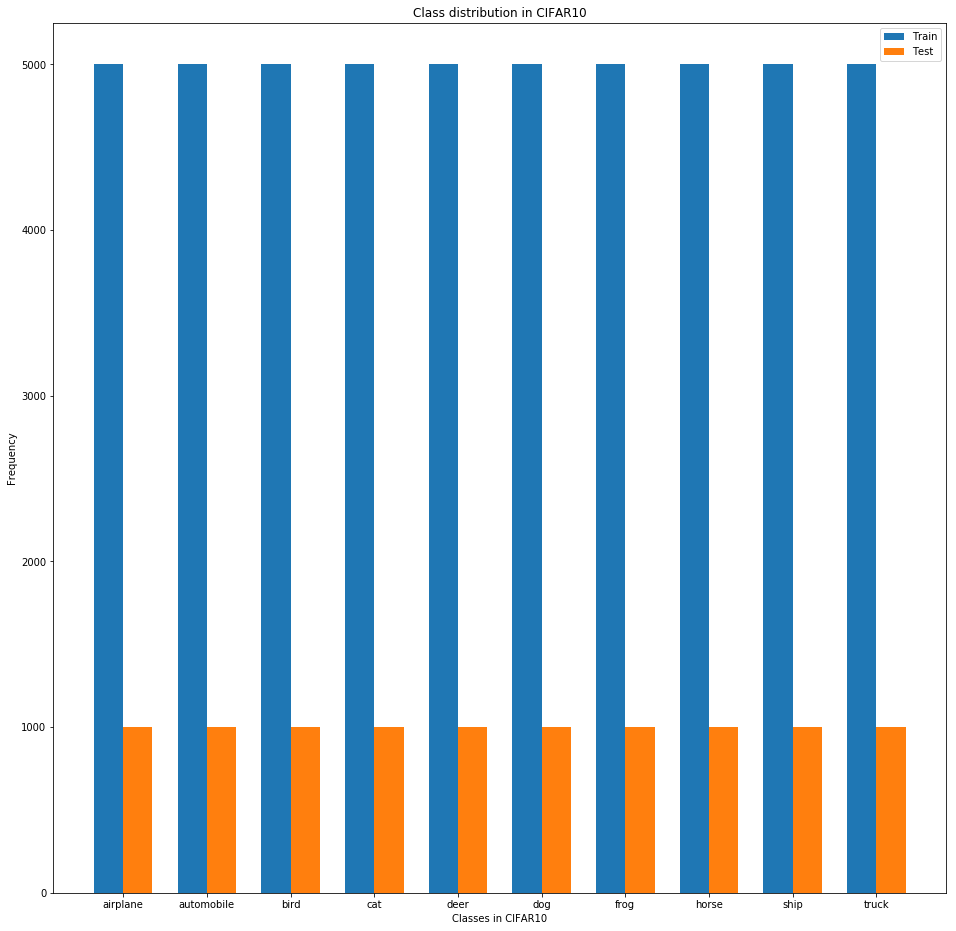

In [26]:
# trainLabels = cifar_dataset.targets
# testLabels = test_dataset.targets

uniqueValuesTrain, occurCountTrain = np.unique(trainLabels, return_counts=True)
uniqueValuesTest, occurCountTest = np.unique(testLabels, return_counts=True)

ind = np.arange(len(occurCountTrain))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16,16))
rects1 = ax.bar(ind - width/2, occurCountTrain, width, 
                label='Train')
rects2 = ax.bar(ind + width/2, occurCountTest, width,
                label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel('Classes in CIFAR10')
ax.set_title('Class distribution in CIFAR10')
ax.set_xticks(ind)
ax.set_xticklabels(labelNames)
ax.legend()
fig.show()

# 3. Training a Deep Neural Network

## 3.1 Setting up device and loading the dataset

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [0]:
batch_size = 200
num_training= 49000
num_validation =1000
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## 3.2 Defining the model

In [0]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
    
        layers = []
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append( nn.ReLU() )

        for i in range(1, len(hidden_layers)):
            
            layers.append( nn.Linear(hidden_layers[i-1], hidden_layers[i]) )
            layers.append( nn.ReLU() )
        
        layers.append( nn.Linear(hidden_layers[-1], num_classes) )
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        
        for i in range(len(self.layers)):
            x = self.layers[i](x)

        out = x
        return out

## 3.3 Initializing weights and updating the learning rate

In [0]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 3.4 Training and testing for one particular hidden size 

In [0]:
def run_training(model, train_loader, learning_rate, learning_rate_decay, num_epochs, early_stopping=True):
    
    model.apply(weights_init)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    total_step = len(train_loader)
    
    valAcc = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(images.reshape(batch_size,-1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                predicted = model(images.reshape(batch_size,-1))
                _ , predicted = torch.max(predicted, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc = 100*correct/total
            valAcc.append(acc)
            print('Validataion accuracy is: {} %'.format(acc))
            
            if early_stopping:
                if acc >= np.amax(valAcc):
                    torch.save(model.state_dict(), path+'DNN_models/ES/model'+str(epoch+1)+'.ckpt')
                    
    best_id = np.argmax(valAcc)
#     model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)
    model.load_state_dict(torch.load(path+'DNN_models/ES/model'+str(best_id+1)+'.ckpt'))
    
    return valAcc

In [0]:
def run_testing(model, test_loader):

    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images.reshape(batch_size,-1))
            _ , predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        testAcc = 100 * correct / total
        print('Accuracy of the network on the {} test images: {} %'.format(total, testAcc))
        
        return testAcc

## 3.5 Training and testing for multiple hidden sizes

In [0]:
def trainMultipleHiddenSizes(listOfHiddenSizes, visualizeES = False, visualizeLayers = False, train = False):
    
    bestESModelValAcc = []
    allValAccs = []
    for hid in range(len(listOfHiddenSizes)):
        print('#################################################')
        print('Training Model ', hid)

        hidden_size = listOfHiddenSizes[hid]

        model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)
        print(model)

        if train:
            valAcc = run_training(model, train_loader, learning_rate, learning_rate_decay, num_epochs)
            allValAccs.append(valAcc)
            bestESModelValAcc.append(np.max(np.array(valAcc)))
            
            # Save the model checkpoint
            torch.save(model.state_dict(), path+'DNN_models/DNN_model'+str(hid)+'.ckpt')
    
    bestModel_ID = np.argmax(np.array(bestESModelValAcc))
    
    if visualizeES:
        valAcc = allValAccs[bestModel_ID]
        epochs = [int(i) for i in range(1, num_epochs+1)]
        ax = plt.figure().gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.plot(epochs,valAcc)
        plt.xlabel('number of epochs')
        plt.ylabel('validation accuracy')
        plt.show()
        
    if visualizeLayers:
        x=[i for i in range(1, len(listOfHiddenSizes)+1)]
        ax = plt.figure().gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.bar(x, bestESModelValAcc)
        plt.xlabel('Layers')
        plt.ylabel('Validation Accuracy')
        plt.show()
        
    return bestModel_ID

In [0]:
def testMultipleParamVals(paramVals, train=False, visualizeTestAcc = False):
    
    testAcc = []
    for hid in range(len(paramVals)):
        hidden_size = paramVals[hid]

        model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)
        if not train:
            # Run the test code once you have your by setting train flag to false
            # and loading the best model

            best_model = torch.load(path+'DNN_models/DNN_model'+str(hid)+'.ckpt')
            model.load_state_dict(best_model)

            testAcc.append(run_testing(model, test_loader))
    
    if visualizeTestAcc:
        x=[i for i in range(1, len(paramVals)+1)]
        ax = plt.figure().gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.bar(x, testAcc)
        plt.xlabel('Models')
        plt.ylabel('Test accuracy')
        plt.show()
    

## 3.6 Params of model

In [0]:
input_size = 32 * 32 * 3
listOfHiddenSizes = [[50], [50, 40], [50, 40, 30], [50, 40, 30, 25], [50, 40, 30, 25, 20]]
num_classes = 10
num_epochs = 10

learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001

#################################################
Training Model  0
MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)
Epoch [1/10], Step [100/245], Loss: 2.1302
Epoch [1/10], Step [200/245], Loss: 1.9243
Validataion accuracy is: 30.7 %
Epoch [2/10], Step [100/245], Loss: 1.8604
Epoch [2/10], Step [200/245], Loss: 1.7947
Validataion accuracy is: 30.7 %
Epoch [3/10], Step [100/245], Loss: 1.8448
Epoch [3/10], Step [200/245], Loss: 1.8054
Validataion accuracy is: 33.8 %
Epoch [4/10], Step [100/245], Loss: 1.9714
Epoch [4/10], Step [200/245], Loss: 1.7882
Validataion accuracy is: 34.3 %
Epoch [5/10], Step [100/245], Loss: 1.6731
Epoch [5/10], Step [200/245], Loss: 1.7742
Validataion accuracy is: 37.5 %
Epoch [6/10], Step [100/245], Loss: 1.7500
Epoch [6/10], Step [200/245], Loss: 1.6347
Validataion accuracy is: 36.1 %
Epoch [7/10], Step [100/245], Loss

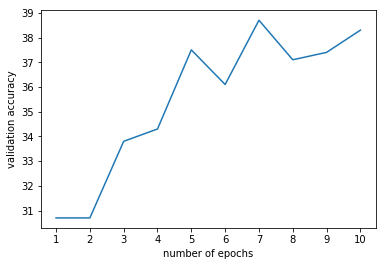

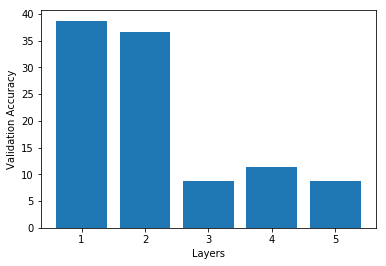

In [306]:
listOfHiddenSizes = [[50], [50, 40], [50, 40, 30], [50, 40, 30, 25], [50, 40, 30, 25, 20]]
train = True
bestModel_ID = trainMultipleHiddenSizes(listOfHiddenSizes, visualizeES = True, visualizeLayers = True, train= train)



In [0]:
train = False 

Accuracy of the network on the 1000 test images: 42.0 %
Accuracy of the network on the 1000 test images: 38.2 %
Accuracy of the network on the 1000 test images: 10.3 %
Accuracy of the network on the 1000 test images: 10.6 %
Accuracy of the network on the 1000 test images: 10.3 %


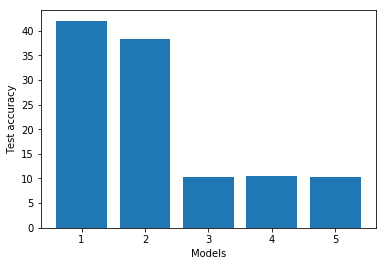

In [308]:
testMultipleParamVals(listOfHiddenSizes, train=train, visualizeTestAcc = True)

# 4. Visualize classification results 

In [0]:
# !pip install seaborn

In [0]:
def display_classification_results(y_test, y_pred,title="Accuracy Heatmap",show_report=True):
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    if show_report:
        print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    ax = sns.heatmap(conf_mat);
    ax.set(title=title, xlabel="Digits", ylabel="Digits")

In [0]:
pickle.dump( bestModel_ID, open( path+"DNN_models/bestModelID.p", "wb" ) )
bestModel_ID = pickle.load( open( path+"DNN_models/bestModelID.p", "rb" ) )

In [0]:
bestmodel = MultiLayerPerceptron(input_size, listOfHiddenSizes[bestModel_ID], num_classes).to(device)
bestmodel.load_state_dict(torch.load(path+'DNN_models/DNN_model'+str(bestModel_ID)+'.ckpt'))

In [0]:
def run_testing_labels(model, test_loader):

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        allPredLabels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images.reshape(batch_size,-1))
            _ , predicted = torch.max(outputs, 1)
            allPredLabels.append(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        testAcc = 100 * correct / total
        print('Accuracy of the network on the {} test images: {} %'.format(total, testAcc))
        
        return testAcc, allPredLabels

In [96]:
testLabels = getLabels(test_dataset)
_, bestModelPreds = run_testing_labels(bestmodel, test_loader)

Accuracy of the network on the 10000 test images: 42.52 %


In [97]:
bestModelPreds = [i.tolist() for i in bestModelPreds]
bestModelPreds = [item for sublist in bestModelPreds for item in sublist]
len(bestModelPreds)

10000

## 4.1 Visualize Accuracy Heatmap

Test accuracy: 42.52%
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.46      0.51      1000
           1       0.42      0.66      0.51      1000
           2       0.39      0.20      0.26      1000
           3       0.33      0.17      0.22      1000
           4       0.48      0.13      0.21      1000
           5       0.32      0.48      0.39      1000
           6       0.53      0.39      0.45      1000
           7       0.37      0.64      0.47      1000
           8       0.55      0.58      0.56      1000
           9       0.40      0.53      0.46      1000

    accuracy                           0.43     10000
   macro avg       0.44      0.43      0.41     10000
weighted avg       0.44      0.43      0.41     10000

Confusion Matrix:
 [[458  97  34  11   5  21  24  65 161 124]
 [ 11 660   4  14   3  19   6  30  62 191]
 [ 96  62 201  66  44 210  61 176  37  47]
 [ 33  72  51 171  12 311  87 146  40  77]
 [ 4

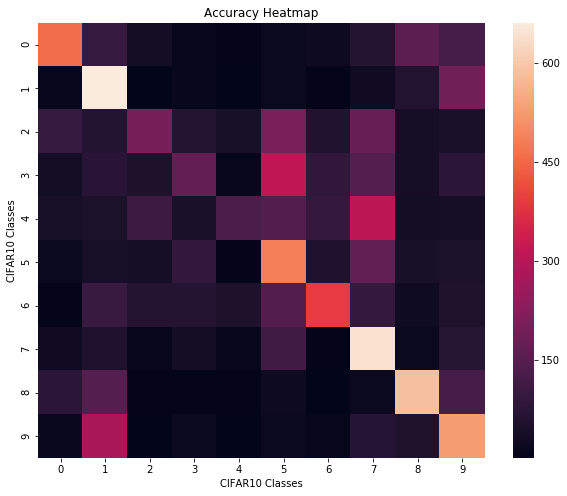

In [98]:
display_classification_results(testLabels, bestModelPreds, title="Accuracy Heatmap",show_report=True)

## 4.2 Visualize correct and incorrect predictions

In [0]:
def visualizePreds(y_test, y_pred, test_dataset, labelNames, visualizeCorrect=False):
    
    correct = np.array(y_test) == np.array(y_pred)
    pos = []
    posPredLabel = []
    posTrueLabel = []
    
    if visualizeCorrect:
        while len(pos) <= 10:
            i = random.randint(0, len(y_pred))
            if y_test[i] == y_pred[i]:

                
                pos.append(i)
                posPredLabel.append(y_pred[i])
                posTrueLabel.append(y_test[i])

    else:
        while len(pos) <= 10:
            i = random.randint(0, len(y_pred))
            if y_test[i] != y_pred[i]:
                pos.append(i)
                posPredLabel.append(y_pred[i])
                posTrueLabel.append(y_test[i])
                
    
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,16))

    i = 0
    for row in ax:
        for col in row:
            img = test_dataset[pos[i]][0]
#             img = np.rollaxis(np.array(img),0,3)
            minVal = float(img.min())
            maxVal = float(img.max())
            col.imshow(toimage(img.data.numpy(), minVal, maxVal))
            col.set_title('True Label: '+str(y_test[pos[i]])+' '+labelNames[y_test[pos[i]]]+'\n Pred Label: '+str(y_pred[pos[i]])+' '+labelNames[y_pred[pos[i]]])
            col.set_xticks([])
            col.set_yticks([])
            i += 1
            
    plt.tight_layout()
    plt.show()

In [ ]:
def toimage(imgArray, minVal, maxVal):
    
    minVal = -1 * minVal    
    imgArray = np.rollaxis(np.array(imgArray),0,3)
    if len(imgArray.shape) == 3:

        processed = []
        for channel in range(3):
            channelImg = imgArray[:,:, channel]

            for i in range(imgArray.shape[0]):
                for j in range(imgArray.shape[1]):
                    channelImg[i,j] = (channelImg[i,j] + minVal) / (minVal+maxVal) 

            processed.append(channelImg)

        img = np.rollaxis(np.array(processed),0,3)
    else:
        img = imgArray[:,:]

        for i in range(imgArray.shape[0]):
            for j in range(imgArray.shape[1]):
                img[i,j] = (img[i,j]+1)/2
            
       
    return img

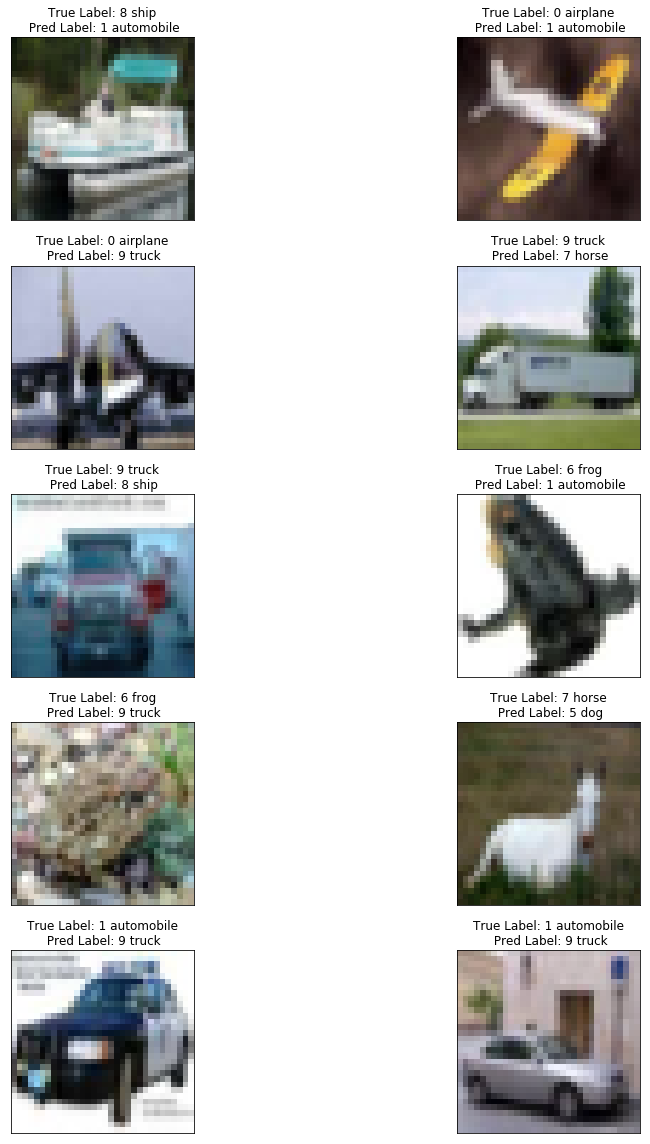

In [163]:
# Visualizing incorrect predictions
visualizePreds(testLabels, bestModelPreds,test_dataset, labelNames)

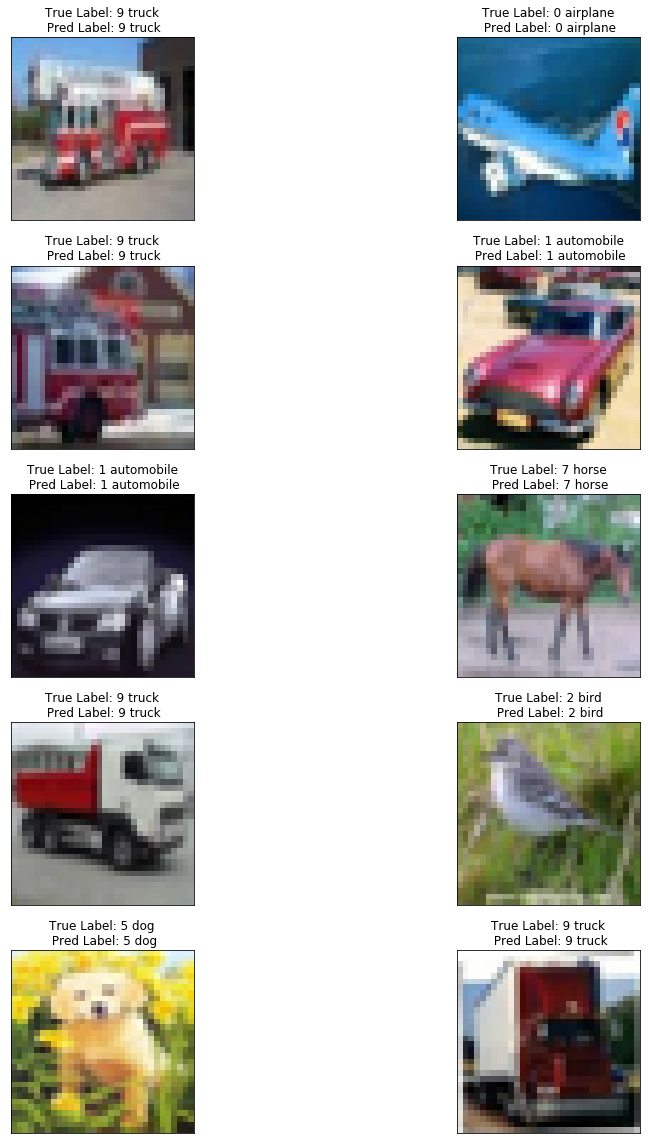

In [164]:
# Visualizing correct predictions
visualizePreds(testLabels, bestModelPreds, test_dataset, labelNames, True)